# Loading first some modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.io import fits

# Loading the MICE mock adapted to KiDS faint

In [2]:
hdul=fits.open('MICE_KiDS.fits')

In [3]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  132 / width of table in bytes                        
NAXIS2  =              5442273 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   24 / number of fields in each row                   
TTYPE1  = 'ra_gal_mag'         / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'dec_gal_mag'        / label for field   2                            
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE3  = 'z_cgal_v'        

In [4]:
df=hdul[1].data

In [5]:
# Computing the luminosity from the r band absolute magnitude
df_luminosity_r=np.power(10., -0.4 * (df['sdss_r_abs_mag'] - 4.76))

# Cut between red and blue galaxies

In [6]:
# For the moment we use a cut in the u-r absolute color vs redshift
df_ur=df['sdss_u_abs_mag']-df['sdss_r_abs_mag']

In [7]:
split_value=1.75

Text(0, 0.5, 'z_cgal_v')

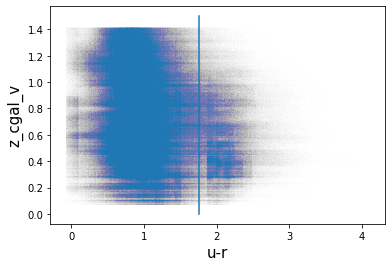

In [8]:
plt.scatter(df_ur,df['z_cgal_v'],s=0.000005)
plt.plot([split_value,split_value],[0,1.5])
plt.xlabel('u-r',fontsize=15)
plt.ylabel('z_cgal_v',fontsize=15)

Text(0.5, 0, 'u-r')

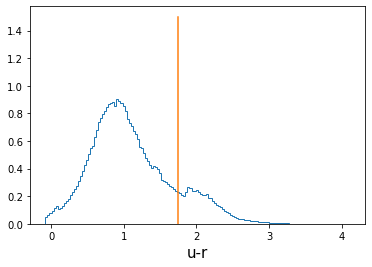

In [9]:
plt.hist(df_ur,histtype='step',bins=150,density=True)
plt.plot([split_value,split_value],[0,1.5])
plt.xlabel('u-r',fontsize=15)

In [10]:
# Redshift edges for the red/blue split histograms
edges=np.linspace(np.min(df['z_cgal_v']),np.max(df['z_cgal_v']),30)

In [11]:
nblue=np.histogram(df['z_cgal_v'][df_ur<=split_value],bins=edges)[0]

In [12]:
nred=np.histogram(df['z_cgal_v'][df_ur>split_value],bins=edges)[0]

In [13]:
zbins=(edges+(edges[1]-edges[0])/2)[:-1]

Text(0, 0.5, 'fraction of blue galaxies')

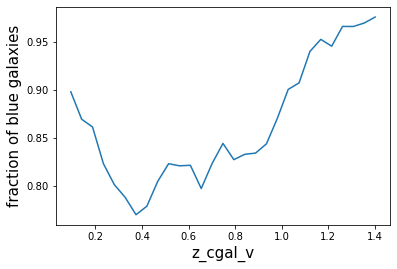

In [14]:
plt.plot(zbins,nblue/(nblue+nred))
plt.xlabel('z_cgal_v',fontsize=15)
plt.ylabel('fraction of blue galaxies',fontsize=15)

# Generating input files for the forecast

In [15]:
# Fraction of red galaxies as a function of redshift
a=open('f_red.txt','w')
for i in range(0,len(zbins)):
    a.write(str(zbins[i]))
    a.write('\t')
    a.write(str(nred[i]/(nblue[i]+nred[i])))
    a.write('\n')

a.close()

In [16]:
# Luminosity limits for red centrals as a function of redshift
a=open('red_cen_lum_pdf.txt','w')
a.write('# z lum_min lum_max')
a.write('\n')
for i in range(1,len(edges)):
    a.write(str((edges[i]+edges[i-1])/2.))
    a.write('\t')
    a.write(str(np.min(df_luminosity_r[(df['z_cgal_v']<edges[i]) & 
                                               (df['z_cgal_v']>=edges[i-1]) &
                                               (df_ur>split_value) &
                                               (df['flag_central']==0)])))
    a.write('\t')
    a.write(str(np.max(df_luminosity_r[(df['z_cgal_v']<edges[i]) & 
                                               (df['z_cgal_v']>=edges[i-1]) &
                                               (df_ur>split_value) &
                                               (df['flag_central']==0)])))
    a.write('\n')
    
a.close()

Text(0.5, 0, 'log_lum')

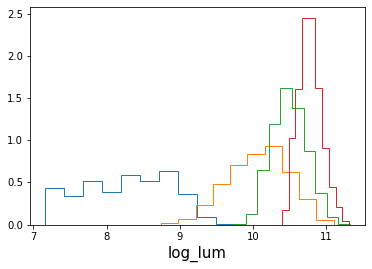

In [17]:
# Check of the luminosity pdfs for red centrals at 4 different redshifts
[plt.hist(np.log10(df_luminosity_r[(df['z_cgal_v']<edges[i]) & 
                                               (df['z_cgal_v']>=edges[i-1]) &
                                               (df_ur>split_value) &
                                               (df['flag_central']==0)]),bins=10,histtype='step',density=True) for i in [1,10,20,29]]
plt.xlabel('log_lum',fontsize=15)

In [18]:
# Luminosity limits for blue centrals as a function of redshift
a=open('blue_cen_lum_pdf.txt','w')
a.write('# z lum_min lum_max')
a.write('\n')
for i in range(1,len(edges)):
    a.write(str((edges[i]+edges[i-1])/2.))
    a.write('\t')
    a.write(str(np.min(df_luminosity_r[(df['z_cgal_v']<edges[i]) & 
                                               (df['z_cgal_v']>=edges[i-1]) &
                                               (df_ur<=split_value) &
                                               (df['flag_central']==0)])))
    a.write('\t')
    a.write(str(np.max(df_luminosity_r[(df['z_cgal_v']<edges[i]) & 
                                               (df['z_cgal_v']>=edges[i-1]) &
                                               (df_ur<=split_value) &
                                               (df['flag_central']==0)])))
    a.write('\n')
    
a.close()

In [19]:
# Luminosity pdfs for blue satellites, red satellites, and red centrals as a function of redshift
c1=fits.Column(name='z', array=df['z_cgal_v'][(df_ur<=split_value) & (df['flag_central']==1)], format='E')
c2=fits.Column(name='loglum', array=np.log10(df_luminosity_r[(df_ur<=split_value) & (df['flag_central']==1)]), format='E')

In [20]:
t=fits.BinTableHDU.from_columns([c1,c2])

In [21]:
t.writeto('bluesat_lum.fits',overwrite=True)

In [22]:
c1=fits.Column(name='z', array=df['z_cgal_v'][(df_ur>split_value) & (df['flag_central']==1)], format='E')
c2=fits.Column(name='loglum', array=np.log10(df_luminosity_r[(df_ur>split_value) & (df['flag_central']==1)]), format='E')

In [23]:
t=fits.BinTableHDU.from_columns([c1,c2])

In [24]:
t.writeto('redsat_lum.fits',overwrite=True)

In [25]:
c1=fits.Column(name='z', array=df['z_cgal_v'][(df_ur>split_value) & (df['flag_central']==0)], format='E')
c2=fits.Column(name='loglum', array=np.log10(df_luminosity_r[(df_ur>split_value) & (df['flag_central']==0)]), format='E')

In [26]:
t=fits.BinTableHDU.from_columns([c1,c2])

In [27]:
t.writeto('redcen_lum.fits',overwrite=True)